In [2]:
import tensorflow as tf
import os
model = tf.saved_model.load("metrabs") 

In [94]:
image = tf.image.decode_jpeg(tf.io.read_file('test1.jpg'),channels = 3)
pred = model.detect_poses(image, skeleton='smpl+head_30')

In [19]:
def plot_results(image, pred, joint_names, joint_edges):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.patches import Rectangle
    fig = plt.figure(figsize=(10, 5.2))
    image_ax = fig.add_subplot(1, 2, 1)
    image_ax.imshow(image.numpy())
    for x, y, w, h, c in pred['boxes'].numpy():
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    pose_ax = fig.add_subplot(1, 2, 2, projection='3d')
    pose_ax.view_init(5, -75)
    pose_ax.set_xlim3d(-1500, 1500)
    pose_ax.set_zlim3d(-1500, 1500)
    pose_ax.set_ylim3d(2000, 5000)
    poses3d = pred['poses3d'].numpy()
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d, pose2d in zip(poses3d, pred['poses2d'].numpy()):
        for i_start, i_end in joint_edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        image_ax.scatter(*pose2d.T, s=2)
        pose_ax.scatter(*pose3d.T, s=2)

In [101]:
poses3d = pred['poses3d'].numpy()
print(poses3d)

[[[-8.44961262e+00  3.57464722e+02  1.69449219e+03]
  [ 3.97188416e+01  4.45018372e+02  1.71414221e+03]
  [-5.44331551e+01  4.46836090e+02  1.69445117e+03]
  [-2.18040161e+01  2.47288666e+02  1.71532104e+03]
  [ 6.19502678e+01  8.10193665e+02  1.72995935e+03]
  [-6.68424072e+01  8.17377136e+02  1.68032788e+03]
  [-2.53562622e+01  9.83225479e+01  1.70706116e+03]
  [ 2.70841637e+01  1.16682446e+03  1.78987244e+03]
  [-3.89775620e+01  1.16534094e+03  1.75334412e+03]
  [-2.25123138e+01  3.89262390e+01  1.69543823e+03]
  [ 8.31781158e+01  1.22522034e+03  1.73493140e+03]
  [-4.18959694e+01  1.21701758e+03  1.68205542e+03]
  [-1.53413696e+01 -1.72463913e+02  1.73051599e+03]
  [ 5.14037247e+01 -6.24135017e+01  1.73592993e+03]
  [-9.00620880e+01 -9.10534515e+01  1.71230896e+03]
  [-1.63320005e+00 -2.54306076e+02  1.69268884e+03]
  [ 1.74166946e+02 -8.22160797e+01  1.75568091e+03]
  [-1.64377762e+02 -1.87062210e+02  1.69844202e+03]
  [ 3.45461884e+02  1.13982422e+02  1.71499731e+03]
  [-2.005218

In [84]:
Pelvis = 0
Left_Hip = 1
Right_Hip = 2
Lower_Back_spine = 3
Left_Knee = 4
Right_Knee = 5
Spine_Middle_Back = 6
Left_Ankle = 7
Right_Ankle = 8
Thorax_Upper_Back = 9
Left_Toe = 10
Right_Toe = 11
Neck = 12
Left_Clavicle = 13
Right_Clavicle = 14
Head = 15
Left_Shoulder = 16
Right_Shoulder = 17
Left_Elbow = 18
Right_Elbow = 19
Left_Wrist = 20
Right_Wrist = 21
Left_Hand = 22
Right_Hand = 23
Nose = 24
Left_Eye = 25
Left_Ear = 26
Right_Eye = 27
Right_Ear = 28
Top_of_Head = 29

In [10]:
import numpy as np
def calculate_angles(keypoints):
    angles = {}

    # Left shoulder angle
    angles['lShoulderAngle'] = calculate_angle(keypoints[0][1], keypoints[0][16], keypoints[0][18])

    # Right shoulder angle
    angles['rShoulderAngle'] = calculate_angle(keypoints[0][2], keypoints[0][17], keypoints[0][19])

    # Left elbow angle
    angles['lElbowAngle'] = calculate_angle(keypoints[0][20], keypoints[0][18], keypoints[0][16])

    # Right elbow angle
    angles['rElbowAngle'] = calculate_angle(keypoints[0][21], keypoints[0][19], keypoints[0][17])

    # Left hip angle
    angles['lHipAngle'] =  calculate_angle(keypoints[0][16], keypoints[0][1], keypoints[0][4])
    # Right hip angle
    angles['rHipAngle'] = calculate_angle(keypoints[0][17], keypoints[0][2], keypoints[0][5])

    # Left knee angle
    angles['lKneeAngle'] = calculate_angle(keypoints[0][1], keypoints[0][4], keypoints[0][7])

    # Right knee angle
    angles['rKneeAngle'] = calculate_angle(keypoints[0][2], keypoints[0][5], keypoints[0][8])
    return angles

def calculate_angle(point1, center, point2):
    vector1 = point1 - center
    vector2 = point2 - center
    dot_product = np.dot(vector1, vector2)
    norm_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)
    cosine_theta = dot_product / norm_product
    angle_radians = np.arccos(cosine_theta)
    angle_degrees = np.degrees(angle_radians)
    return angle_degrees

In [70]:
def calculate_distance(point1, point2):
    
    # Calculate the difference between the points
    diff = point2 - point1
    
    # Calculate the squared Euclidean distance
    distance_squared = np.sum(diff**2)
    
    # Take the square root to get the Euclidean distance
    distance = np.sqrt(distance_squared)
    
    return distance

In [98]:
# Calculate angle between points
angle = calculate_angles(poses3d)
print("Joint angles in 3d space : \n")
for i in angle:
    print(f"{i} = {angle[i]}")

Joint angles in 3d space : 

lShoulderAngle = 55.19756317138672
rShoulderAngle = 155.5150604248047
lElbowAngle = 120.62374114990234
rElbowAngle = 108.18840789794922
lHipAngle = 160.95236206054688
rHipAngle = 168.10462951660156
lKneeAngle = 168.5784454345703
rKneeAngle = 164.58651733398438


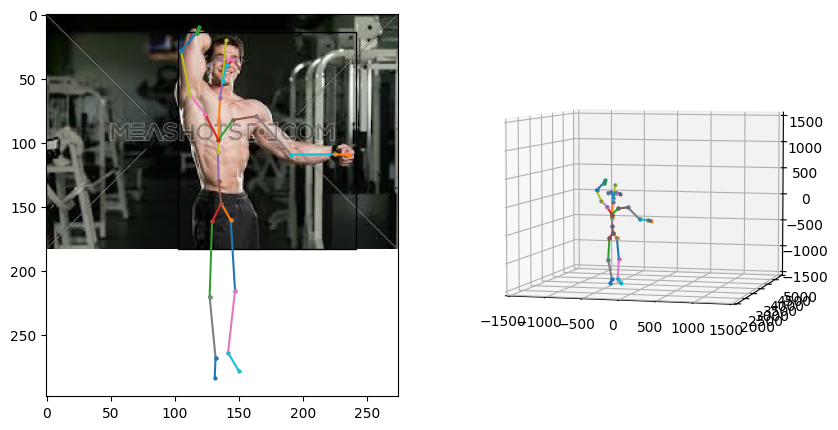

In [95]:
joint_names = model.per_skeleton_joint_names['smpl+head_30'].numpy().astype(str)
joint_edges = model.per_skeleton_joint_edges['smpl+head_30'].numpy()
plot_results(image, pred, joint_names, joint_edges)

In [99]:
larm = calculate_distance(poses3d[0][20],poses3d[0][18]) + calculate_distance(poses3d[0][18],poses3d[0][16])
rarm = calculate_distance(poses3d[0][21],poses3d[0][19]) + calculate_distance(poses3d[0][19],poses3d[0][17])
body_height = max(calculate_distance(poses3d[0][29],poses3d[0][8]),calculate_distance(poses3d[0][29],poses3d[0][7]))


In [100]:
print("Left Arm length " ,larm)
print("Right Arm length " ,rarm)
print("Body height = ",body_height)
print("Ratio of arm to body =",larm/body_height)

Left Arm length  506.76096
Right Arm length  387.26593
Body height =  1637.1566
Ratio of arm to body = 0.30953726


In [18]:
!python images_for_projection.py VID20220619095305.mp4 tennis_rnn.h5 --left-handed

starting

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.

0: 384x640 1 racket, 161.4ms
Speed: 6.8ms preprocess, 161.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 138.4ms
Speed: 4.6ms preprocess, 138.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 147.0ms
Speed: 0.0ms preprocess, 147.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 racket, 142.3ms
Speed: 0.0ms preprocess, 142.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 racket, 139.0ms
Speed: 2.7ms preprocess, 139.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 racket, 127.9ms
Speed: 2.0ms preprocess, 127.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 racket, 142.0ms
Speed: 0.0ms preprocess, 142.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ra


frame_numbers
POC happens at :  [29, 279, 354, 386, 450, 490, 585, 737, 811, 847, 976, 1128]
final pocs are :  [29, 279, 354, 386, 450, 490, 585, 737, 811, 847, 976, 1128]


In [19]:
!python images_for_projection.py coco_for_maintest.mp4 tennis_rnn.h5 --left-handed

starting

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.

0: 384x640 1 ball, 1 overlap, 1 racket, 136.1ms
Speed: 21.0ms preprocess, 136.1ms inference, 8.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 racket, 132.4ms
Speed: 0.0ms preprocess, 132.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 2 rackets, 125.9ms
Speed: 0.0ms preprocess, 125.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 2 overlaps, 1 racket, 128.9ms
Speed: 0.0ms preprocess, 128.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 overlap, 1 racket, 123.6ms
Speed: 0.0ms preprocess, 123.6ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 overlap, 1 racket, 127.4ms
Speed: 0.0ms preprocess, 127.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 2 overlaps, 1 racket, 125.2ms
Speed: 0.0ms preprocess, 125.2


frame_numbers
POC happens at :  [11, 101, 198, 282, 329, 410, 492, 570]
final pocs are :  [11, 101, 198, 282, 329, 410, 492, 570]


In [3]:
import csv

def separate_csv_by_shot_type(input_file, forehand_output_file, backhand_output_file):
  """
  Separates a CSV file into two based on the 'shot type' column.

  Args:
      input_file (str): Path to the input CSV file.
      forehand_output_file (str): Path to the output CSV file for forehands.
      backhand_output_file (str): Path to the output CSV file for backhands.
  """

  with open(input_file, 'r') as infile, open(forehand_output_file, 'w', newline='') as forehand_outfile, open(backhand_output_file, 'w', newline='') as backhand_outfile:
    reader = csv.reader(infile)
    forehand_writer = csv.writer(forehand_outfile)
    backhand_writer = csv.writer(backhand_outfile)

    # Copy the header row from the original file
    header = next(reader)
    forehand_writer.writerow(header)
    backhand_writer.writerow(header)

    for row in reader:
      shot_type = row[0]
      if shot_type == "forehand":
        forehand_writer.writerow(row)
      elif shot_type == "backhand":
        backhand_writer.writerow(row)
      else:
        # Handle rows with unexpected shot types (optional)
        print(f"Warning: Unexpected shot type: {shot_type} in row: {row}")

if __name__ == "__main__":
  input_file = "Shot_phases.csv"
  forehand_output_file = "forehand_shots.csv"
  backhand_output_file = "backhand_shots.csv"
  separate_csv_by_shot_type(input_file, forehand_output_file, backhand_output_file)
  print("CSV files separated successfully!")

CSV files separated successfully!


In [25]:
!python yoga1.py 3d_testing/ tennis_rnn.h5

['gym_testing_for_3d.jpg', 'jesus_pose_side.jpg', 'mypose.png', 'test1.jpg']
[     162.93      308.66      224.99      255.94      228.98      273.86      327.34      257.26         339      377.97      295.07      354.37       244.1       407.2      411.55      233.08      417.57      260.07      367.19      333.31      409.44      371.65      388.18      296.98      246.14      408.73]
{'lShoulderAngle': 7.725126144374725, 'rShoulderAngle': 47.60453489155236, 'lElbowAngle': 72.35504697035996, 'rElbowAngle': 60.539870490888255, 'lHipAngle': 59.140971399489416, 'rHipAngle': 81.65128118718184, 'lKneeAngle': 6.1435506899839405, 'rKneeAngle': 106.95566466621695}
[     49.521      170.58      74.088      163.92      76.739      159.53      81.904      157.94      85.638      155.31      68.984      139.71       75.24      134.79      166.94      172.02       169.7      160.08      197.27      233.12      208.39      230.39      198.37      169.88      205.78      162.31]
{'lShoulderAngle':

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
!python track_and_classify_with_rnn.py coco_for_maintest.mp4 tennis_rnn.h5

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.

0: 384x640 1 ball, 1 overlap, 1 racket, 283.5ms
Speed: 15.6ms preprocess, 283.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 racket, 268.4ms
Speed: 0.0ms preprocess, 268.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 2 rackets, 247.4ms
Speed: 0.0ms preprocess, 247.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 2 overlaps, 1 racket, 255.1ms
Speed: 0.0ms preprocess, 255.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 overlap, 1 racket, 255.0ms
Speed: 0.0ms preprocess, 255.0ms inference, 5.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 overlap, 1 racket, 251.1ms
Speed: 7.0ms preprocess, 251.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 2 overlaps, 1 racket, 256.3ms
Speed: 0.0ms preprocess, 256.3m

In [12]:
!python track_and_classify_with_rnn.py alcaraz_poc_testing.mp4 tennis_rnn.h5

RNN POCS extracted from shot_counter results:  [70, 166, 261, 359]
final_poc :  [161, 256, 354]
shot_counter results:  [{'FrameID': 70, 'Shot': 'backhand'}, {'FrameID': 166, 'Shot': 'backhand'}, {'FrameID': 261, 'Shot': 'forehand'}, {'FrameID': 359, 'Shot': 'forehand'}]
[{'FrameID': 166, 'Shot': 'backhand'}, {'FrameID': 261, 'Shot': 'forehand'}, {'FrameID': 359, 'Shot': 'forehand'}]
detect final_poc:  [161, 256, 354]
probability_list ;  [{30: <tf.Tensor: shape=(4,), dtype=float32, numpy=array([  0.0002674,   0.0018102,     0.99791,  7.7361e-06], dtype=float32)>}, {31: <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.00016634,   0.0018078,     0.99802,  4.8167e-06], dtype=float32)>}, {32: <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.00016579,   0.0018751,     0.99795,  5.4499e-06], dtype=float32)>}, {33: <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.00015867,   0.0019577,     0.99788,  5.8721e-06], dtype=float32)>}, {34: <tf.Tensor: shape=(4,), dtype=float32, nu

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.

0: 384x640 (no detections), 267.1ms
Speed: 0.0ms preprocess, 267.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 237.3ms
Speed: 0.0ms preprocess, 237.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 235.3ms
Speed: 14.0ms preprocess, 235.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 236.3ms
Speed: 15.6ms preprocess, 236.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 250.1ms
Speed: 0.0ms preprocess, 250.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 250.9ms
Speed: 0.0ms preprocess, 250.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 235.3ms
Speed: 0.0ms preprocess, 235.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 64

In [13]:
!python track_and_classify_with_rnn.py coco_for_maintest.mp4 tennis_rnn.h5

Lost player track --> reset ROI because prob is too low = 0.2564871563361241
Lost player track --> reset ROI because height = 104 and width = 14
Lost player track --> reset ROI because height = 105 and width = 27
Lost player track --> reset ROI because height = 146 and width = 850
Lost player track --> reset ROI because height = 117 and width = 574
Lost player track --> reset ROI because height = 62 and width = 578
Lost player track --> reset ROI because height = 66 and width = 22
Lost player track --> reset ROI because height = 141 and width = 1076
Lost player track --> reset ROI because height = 141 and width = 1034
Lost player track --> reset ROI because height = 141 and width = 945
Lost player track --> reset ROI because prob is too low = 0.18867035554005548
RNN POCS extracted from shot_counter results:  [88, 171, 496, 574]
final_poc :  [84, 168, 490, 570]
shot_counter results:  [{'FrameID': 88, 'Shot': 'forehand'}, {'FrameID': 171, 'Shot': 'forehand'}, {'FrameID': 496, 'Shot': 'ba

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.

0: 384x640 1 ball, 1 overlap, 1 racket, 299.0ms
Speed: 0.0ms preprocess, 299.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 racket, 276.9ms
Speed: 0.0ms preprocess, 276.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 2 rackets, 248.3ms
Speed: 3.1ms preprocess, 248.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 2 overlaps, 1 racket, 251.2ms
Speed: 2.1ms preprocess, 251.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 overlap, 1 racket, 252.0ms
Speed: 2.5ms preprocess, 252.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 overlap, 1 racket, 268.2ms
Speed: 0.0ms preprocess, 268.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 2 overlaps, 1 racket, 266.7ms
Speed: 0.0ms preprocess, 266.7ms

In [ ]:
!python track_and_classify_with_rnn.py coco_video1.mp4 tennis_rnn.h5

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.

0: 384x640 2 rackets, 346.1ms
Speed: 3.5ms preprocess, 346.1ms inference, 18.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 252.3ms
Speed: 3.0ms preprocess, 252.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 261.0ms
Speed: 4.2ms preprocess, 261.0ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 264.0ms
Speed: 0.0ms preprocess, 264.0ms inference, 6.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 258.4ms
Speed: 9.5ms preprocess, 258.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 249.9ms
Speed: 3.2ms preprocess, 249.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 259.4ms
Speed: 0.0ms preprocess, 259.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 249.7ms
Speed: 0.0ms pre

Lost player track --> reset ROI because prob is too low = 0.2997825816273689
Lost player track --> reset ROI because prob is too low = 0.29481642292096066
Lost player track --> reset ROI because height = 55 and width = 9
Lost player track --> reset ROI because prob is too low = 0.23955753101752356
Lost player track --> reset ROI because prob is too low = 0.29171805255688155
Lost player track --> reset ROI because prob is too low = 0.29037501118504083
Lost player track --> reset ROI because height = 83 and width = 585
Lost player track --> reset ROI because height = 62 and width = 16
Lost player track --> reset ROI because height = 63 and width = 18
Lost player track --> reset ROI because height = 61 and width = 23
Lost player track --> reset ROI because prob is too low = 0.29477595595213085
Lost player track --> reset ROI because prob is too low = 0.21073259355930182
Lost player track --> reset ROI because prob is too low = 0.23337713113197914
RNN POCS extracted from shot_counter resul

In [1]:
!python track_and_classify_with_rnn.py Nadal_new_csv.mp4 tennis_rnn.h5 --left-handed

Lost player track --> reset ROI because prob is too low = 0.2931897141612493
Lost player track --> reset ROI because prob is too low = 0.1920859209046914
Lost player track --> reset ROI because prob is too low = 0.2898928735118646
Lost player track --> reset ROI because height = 126 and width = 28
Lost player track --> reset ROI because height = 111 and width = 31
Lost player track --> reset ROI because height = 96 and width = 33
Lost player track --> reset ROI because height = 107 and width = 24
Lost player track --> reset ROI because height = 94 and width = 29
Lost player track --> reset ROI because height = 98 and width = 36
Lost player track --> reset ROI because height = 92 and width = 22
Lost player track --> reset ROI because height = 109 and width = 27
Lost player track --> reset ROI because height = 115 and width = 16
Lost player track --> reset ROI because height = 117 and width = 32
Lost player track --> reset ROI because height = 113 and width = 23
Lost player track --> res

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.

0: 384x640 1 racket, 383.0ms
Speed: 22.2ms preprocess, 383.0ms inference, 28.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 263.0ms
Speed: 0.0ms preprocess, 263.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 261.1ms
Speed: 0.0ms preprocess, 261.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 248.3ms
Speed: 15.6ms preprocess, 248.3ms inference, 9.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 243.8ms
Speed: 0.0ms preprocess, 243.8ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 247.4ms
Speed: 4.1ms preprocess, 247.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 263.7ms
Speed: 0.0ms preprocess, 263.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 255.5ms
Speed: 4.1ms p


shot inittiated at frame :  1718
shot ended at frame :  [1724, 1759]
shot inittiated at frame :  1804
shot ended at frame :  [1827, 1847]
shot inittiated at frame :  1897
shot ended at frame :  [1909, 1938]
shot inittiated at frame :  1970
shot ended at frame :  [1989, 2017]
shot inittiated at frame :  2099
shot ended at frame :  [2119, 2154]
shot inittiated at frame :  2274
shot ended at frame :  [2280, 2315]
shot inittiated at frame :  2337
shot ended at frame :  [2357, 2385]
shot inittiated at frame :  2432
shot ended at frame :  [2447, 2476]
shot inittiated at frame :  2525
shot ended at frame :  [2527, 2562]
shot inittiated at frame :  2588
shot ended at frame :  [2601, 2630]
shot inittiated at frame :  2663
shot ended at frame :  [2678, 2703]
shot inittiated at frame :  2737
shot ended at frame :  [2757, 2787]
shot inittiated at frame :  3179
shot ended at frame :  [3183, 3205]
shot inittiated at frame :  3321
shot ended at frame :  [3331, 3355]
shot inittiated at frame :  3399


In [17]:
!python track_and_classify_with_rnn.py VID20220619095305.mp4 tennis_rnn.h5 --left-handed

Lost player track --> reset ROI because prob is too low = 0.29748302096357715
Lost player track --> reset ROI because prob is too low = 0.27646625213898146
Lost player track --> reset ROI because prob is too low = 0.2656114496863805
Lost player track --> reset ROI because prob is too low = 0.25559295155107975
Lost player track --> reset ROI because height = 132 and width = 48
Lost player track --> reset ROI because prob is too low = 0.2987146101032312
Lost player track --> reset ROI because prob is too low = 0.2949562737574944
Lost player track --> reset ROI because prob is too low = 0.23209221431842217
Lost player track --> reset ROI because prob is too low = 0.18881424917624548
Lost player track --> reset ROI because prob is too low = 0.20704155100079683
Lost player track --> reset ROI because prob is too low = 0.17362356529786035
Lost player track --> reset ROI because prob is too low = 0.1475766753921142
Lost player track --> reset ROI because height = 131 and width = 18
Lost playe

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.

0: 384x640 1 racket, 298.8ms
Speed: 0.0ms preprocess, 298.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 282.0ms
Speed: 0.0ms preprocess, 282.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 292.7ms
Speed: 0.0ms preprocess, 292.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 racket, 251.5ms
Speed: 0.0ms preprocess, 251.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 racket, 250.5ms
Speed: 15.6ms preprocess, 250.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 racket, 251.5ms
Speed: 0.0ms preprocess, 251.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 1 racket, 251.5ms
Speed: 0.0ms preprocess, 251.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 r

In [21]:
!python track_and_classify_with_rnn.py VID20220619095238.mp4 tennis_rnn.h5 --left-handed

RNN POCS extracted from shot_counter results:  [55, 164, 262, 500, 614]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.

0: 384x640 1 racket, 340.0ms
Speed: 15.1ms preprocess, 340.0ms inference, 14.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 268.9ms
Speed: 0.0ms preprocess, 268.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 300.0ms
Speed: 15.0ms preprocess, 300.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 254.1ms
Speed: 8.7ms preprocess, 254.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 264.2ms
Speed: 0.0ms preprocess, 264.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 261.3ms
Speed: 2.9ms preprocess, 261.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 258.4ms
Speed: 7.1ms preprocess, 258.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detectio


final_poc :  [54, 161, 259, 495, 611]

shot_counter results:  [{'FrameID': 55, 'Shot': 'forehand'}, {'FrameID': 164, 'Shot': 'forehand'}, {'FrameID': 262, 'Shot': 'forehand'}, {'FrameID': 500, 'Shot': 'forehand'}, {'FrameID': 614, 'Shot': 'forehand'}]

 [{'FrameID': 55, 'Shot': 'forehand'}, {'FrameID': 164, 'Shot': 'forehand'}, {'FrameID': 262, 'Shot': 'forehand'}, {'FrameID': 500, 'Shot': 'forehand'}, {'FrameID': 614, 'Shot': 'forehand'}]

detect final_poc:  [54, 161, 259, 495, 611]
------ For Backhand ------
Preparation time: 11, Follow through time: 33

------ For Forehand ------
Preparation time: 12, Follow through time: 29

Shot played:  forehand
Preparation time in frames:  4
follow through time in frames:  23
Took good preparation time before POC
Took good follow through time after POC

Shot played:  forehand
Preparation time in frames:  3
follow through time in frames:  22
Took good preparation time before POC
Took good follow through time after POC

Shot played:  forehand
Pre

In [26]:
!python track_and_classify_with_rnn.py VID20220619095238.mp4 tennis_rnn.h5 --left-handed

RNN POCS extracted from shot_counter results:  [55, 164, 262, 500, 614]
final_poc :  [54, 161, 259, 495, 611]

shot_counter results:  [{'FrameID': 55, 'Shot': 'forehand'}, {'FrameID': 164, 'Shot': 'forehand'}, {'FrameID': 262, 'Shot': 'forehand'}, {'FrameID': 500, 'Shot': 'forehand'}, {'FrameID': 614, 'Shot': 'forehand'}]

 [{'FrameID': 55, 'Shot': 'forehand'}, {'FrameID': 164, 'Shot': 'forehand'}, {'FrameID': 262, 'Shot': 'forehand'}, {'FrameID': 500, 'Shot': 'forehand'}, {'FrameID': 614, 'Shot': 'forehand'}]

detect final_poc:  [54, 161, 259, 495, 611]
------ For Backhand ------
Preparation time: 11, Follow through time: 33

------ For Forehand ------
Preparation time: 12, Follow through time: 29

Shot played:  forehand
Preparation time in frames:  4
follow through time in frames:  23
Took good preparation time before POC
Took good follow through time after POC

Shot played:  forehand
Preparation time in frames:  3
follow through time in frames:  22
Took good preparation time before 

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.

0: 384x640 1 racket, 155.2ms
Speed: 3.8ms preprocess, 155.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 140.9ms
Speed: 0.0ms preprocess, 140.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 143.4ms
Speed: 0.0ms preprocess, 143.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 141.8ms
Speed: 6.5ms preprocess, 141.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 138.4ms
Speed: 0.0ms preprocess, 138.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 133.1ms
Speed: 2.7ms preprocess, 133.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 126.5ms
Speed: 4.0ms preprocess, 126.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections)

In [6]:
!python yoga.py fore_wrong_pos.png tennis_rnn.h5

angles are:  {'lShoulderAngle': 75.11106120971695, 'rShoulderAngle': 29.770159710361714, 'lElbowAngle': 80.9827419270821, 'rElbowAngle': 54.61601745565405, 'lHipAngle': 161.45676722292248, 'rHipAngle': 153.62805544983735, 'lKneeAngle': 153.83776178546825, 'rKneeAngle': 137.1432658375826}

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.



Video created


In [10]:
!python track_and_classify_with_rnn.py VID20220619095238.mp4 tennis_rnn.h5 --left-handed

RNN POCS extracted from shot_counter results:  [55, 164, 262, 500, 614]
final_poc :  [54, 161, 259, 495, 611]

shot_counter results:  [{'FrameID': 55, 'Shot': 'forehand'}, {'FrameID': 164, 'Shot': 'forehand'}, {'FrameID': 262, 'Shot': 'forehand'}, {'FrameID': 500, 'Shot': 'forehand'}, {'FrameID': 614, 'Shot': 'forehand'}]

 [{'FrameID': 55, 'Shot': 'forehand'}, {'FrameID': 164, 'Shot': 'forehand'}, {'FrameID': 262, 'Shot': 'forehand'}, {'FrameID': 500, 'Shot': 'forehand'}, {'FrameID': 614, 'Shot': 'forehand'}]

detect final_poc:  [54, 161, 259, 495, 611]
------ For Backhand ------
Preparation time: 11, Follow through time: 33

------ For Forehand ------
Preparation time: 12, Follow through time: 29

Shot played:  forehand
Preparation time in frames:  4
follow through time in frames:  23
Took good preparation time before POC
Took good follow through time after POC

Shot played:  forehand
Preparation time in frames:  3
follow through time in frames:  22
Took good preparation time before 

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.

0: 384x640 1 racket, 215.0ms
Speed: 0.0ms preprocess, 215.0ms inference, 11.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 141.6ms
Speed: 0.0ms preprocess, 141.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 142.4ms
Speed: 0.0ms preprocess, 142.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 141.1ms
Speed: 0.0ms preprocess, 141.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 133.9ms
Speed: 15.6ms preprocess, 133.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 141.6ms
Speed: 0.0ms preprocess, 141.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 133.7ms
Speed: 15.6ms preprocess, 133.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detectio

In [13]:
!python track_and_classify_with_rnn.py VID20220619095238.mp4 tennis_rnn.h5 --left-handed

RNN POCS extracted from shot_counter results:  [55, 164, 262, 500, 614]
final_poc :  [54, 161, 259, 495, 611]

shot_counter results:  [{'FrameID': 55, 'Shot': 'forehand'}, {'FrameID': 164, 'Shot': 'forehand'}, {'FrameID': 262, 'Shot': 'forehand'}, {'FrameID': 500, 'Shot': 'forehand'}, {'FrameID': 614, 'Shot': 'forehand'}]

 [{'FrameID': 55, 'Shot': 'forehand'}, {'FrameID': 164, 'Shot': 'forehand'}, {'FrameID': 262, 'Shot': 'forehand'}, {'FrameID': 500, 'Shot': 'forehand'}, {'FrameID': 614, 'Shot': 'forehand'}]

detect final_poc:  [54, 161, 259, 495, 611]
------ For Backhand ------
Preparation time: 11, Follow through time: 33

------ For Forehand ------
Preparation time: 12, Follow through time: 29

Shot played:  forehand
Preparation time in frames:  4
follow through time in frames:  23
Took good preparation time before POC
Took good follow through time after POC

Shot played:  forehand
Preparation time in frames:  3
follow through time in frames:  22
Took good preparation time before 

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.

0: 384x640 1 racket, 200.1ms
Speed: 0.0ms preprocess, 200.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 135.2ms
Speed: 0.0ms preprocess, 135.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 140.3ms
Speed: 0.0ms preprocess, 140.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 125.4ms
Speed: 15.6ms preprocess, 125.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 racket, 141.4ms
Speed: 0.0ms preprocess, 141.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 125.4ms
Speed: 15.6ms preprocess, 125.4ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 142.2ms
Speed: 0.0ms preprocess, 142.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detectio